In [1]:
# load modules
import json
import os
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict, Counter, OrderedDict
import bhtsne
import scanpy
import scipy
import phenograph # install from https://github.com/jacoblevine/PhenoGraph
from pandas.core.index import RangeIndex
from scipy.io import mmread,mminfo
import gzip

# Plotting imports
import matplotlib
from matplotlib import cm 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib.colors import ListedColormap
from random import shuffle
import matplotlib.patches as mpatches

#sklearn
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
#Stats imports
import scipy.stats as stats

import magic # install from https://github.com/pkathail/magic/
#import warnings
import random
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


# Load Data Objects

In [2]:
path=f"{os.getcwd()}/filtered_gene_bc_matrices/GRCh38"
gene_path = f"{path}/genes.tsv"
barcode_path = f"{path}/barcodes.tsv"
matrix_path = f"{path}/matrix.mtx"

In [3]:
gene_df=pd.read_csv(gene_path,sep='\t', names=['geneid','gene_name'])
barcode_df = pd.read_csv(barcode_path,sep='\t',names=['barcode'])

In [4]:
sparse_matrix = mmread(matrix_path)
desnse_matrix = sparse_matrix.todense()
dense_matrix_T = desnse_matrix.T
df = pd.DataFrame(dense_matrix_T)

# Q1

## Q1a. 
Filter the data if needed, and normalize the data by scaling to median library size. Project the log transformed normalized data to 2D using t-SNE or UMAP. Plot the 2D or 3D embedding [15pts].

## Filtering

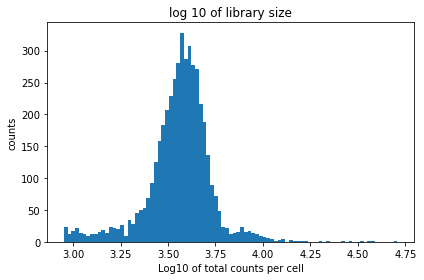

In [5]:
counts_log10 = np.log10(df.sum(axis=1))
plt.hist(counts_log10,bins='auto')
plt.title('log 10 of library size')
plt.xlabel('Log10 of total counts per cell')
plt.ylabel('counts')
plt.tight_layout()

In [7]:
#filtering 
threshold = 3.3
ms = df.sum(axis=1)
use_cells = ms.index[np.log10(ms) > threshold]
reduced_df = df.loc[use_cells]

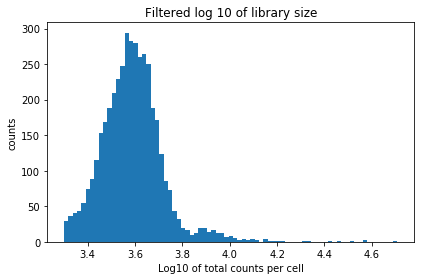

In [8]:
counts_log10 = np.log10(reduced_df.sum(axis=1))
plt.hist(counts_log10,bins='auto')
plt.title('Filtered log 10 of library size')
plt.xlabel('Log10 of total counts per cell')
plt.ylabel('counts')
plt.tight_layout()

In [9]:
#filtering 
threshold=3.85
ms = reduced_df.sum(axis=1)
use_cells = ms.index[np.log10(ms) < threshold]
reduced_df = reduced_df.loc[use_cells]

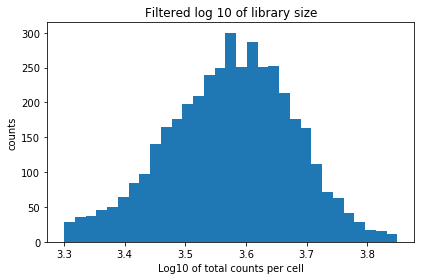

In [10]:
counts_log10 = np.log10(reduced_df.sum(axis=1))
plt.hist(counts_log10,bins='auto')
plt.title('Filtered log 10 of library size')
plt.xlabel('Log10 of total counts per cell')
plt.ylabel('counts')
plt.tight_layout()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


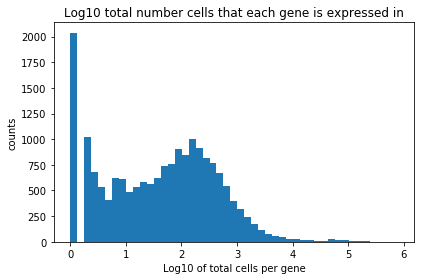

In [11]:
# Distrbution 
counts_log10 = np.log10(reduced_df.sum(axis=0))
plt.hist(counts_log10,bins='auto', range=(0,counts_log10.max()))
plt.title('Log10 total number cells that each gene is expressed in')
plt.xlabel('Log10 of total cells per gene')
plt.ylabel('counts')
plt.tight_layout()

In [14]:
ms=reduced_df.sum(axis=0)
use_genes = ms.index[np.log10(ms) > .5]
reduced_df = reduced_df[use_genes]

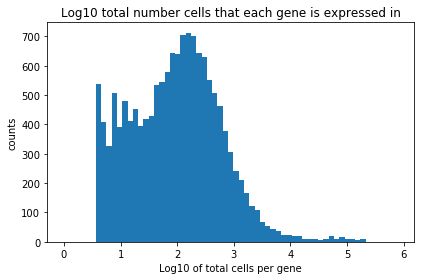

In [15]:
# Distrbution 
counts_log10 = np.log10(reduced_df.sum(axis=0))
plt.hist(counts_log10,bins='auto', range=(0,counts_log10.max()))
plt.title('Log10 total number cells that each gene is expressed in')
plt.xlabel('Log10 of total cells per gene')
plt.ylabel('counts')
plt.tight_layout()

In [18]:
print(f"{df.shape[0]-reduced_df.shape[0]} cells removed")
print(f"{df.shape[1]-reduced_df.shape[1]} genes removed")

462 cells removed
19142 genes removed


## Normalizing

In [19]:
#normalizing the data & taking log10 
ms = reduced_df.sum(axis=1) #library size
norm_df = reduced_df.div(ms, axis=0).mul(np.median(ms), axis=0) #normalize by lib size
log_df = np.log(0.1+ norm_df) #log of normalized df

## Visualization

In [26]:
from sklearn.decomposition import PCA
no_eigs = 100
pca_1 = PCA(n_components=no_eigs)
pca_1.fit(log_df.values)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

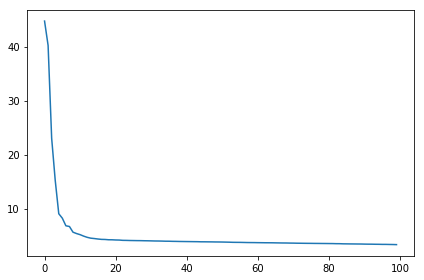

In [27]:
# Get Eiganvectors
eig_vectors = pca_1.components_
# Get Eiganvalues
eig_values = pca_1.explained_variance_
plt.plot(eig_values)
plt.tight_layout()

In [28]:
pca= PCA(n_components=25)
pca_results = pd.DataFrame(pca.fit_transform(log_df),
                index=log_df.index)

In [32]:
import umap

def perform_umap(pca_dataframe,neighbors=15): #15-50 neighbors
    reducer = umap.UMAP(n_neighbors=neighbors)
    embedding = reducer.fit_transform(pca_dataframe)
    return embedding

def graph_umap(raw_df,norm_df,umap_output,title):
    ms=raw_df.sum(axis=1)
    plt.figure(figsize=[5, 3.5])
    plt.scatter(umap_output[:, 0],umap_output[:, 1],s=5, edgecolors='none',
        cmap=matplotlib.cm.Spectral_r, c=np.log10(ms[norm_df.index]))
    plt.title(f'{title} UMAP colored by log 10 of expression')
    plt.colorbar()
    
def perform_tsne(num_PC,pca_projections, perplexity, log_df):
    use_eigs = list(range(1, num_PC))
    data = pca_projections.values[:, use_eigs] 
    # tsNE
    tsne = pd.DataFrame(bhtsne.tsne(data, perplexity=perplexity), 
                index=log_df.index, columns=['x', 'y'])
    return tsne

def graph_tsne(raw_df,norm_df,tsne,title):
    ms = raw_df.sum(axis=1)
    plt.figure(figsize=[5, 3.5])
    plt.scatter(tsne['x'], tsne['y'], s=5, edgecolors='none',
        cmap=matplotlib.cm.Spectral_r, c=np.log10(ms[norm_df.index]))
    plt.title(f'{title} tSNE colored by log 10 of expression')
    plt.colorbar()

def side_by_side(tsne,umap,raw_df,norm_df,title):
    ms=raw_df.sum(axis=1)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    #umap
    plot1=ax[0].scatter(umap[:, 0],umap[:, 1],s=5, edgecolors='none', cmap=matplotlib.cm.Spectral_r, c=np.log10(ms[norm_df.index]))
    ax[0].set_title(f"UMAP of {title}")
    fig.colorbar(plot1,ax=ax[0])
    #tsne
    plot2=ax[1].scatter(tsne['x'], tsne['y'], s=5, edgecolors='none', cmap=matplotlib.cm.Spectral_r, c=np.log10(ms[norm_df.index]))
    ax[1].set_title(f"tSNE of {title}")
    fig.colorbar(plot2,ax=ax[1])

In [24]:
umap_output = perform_umap(log_df)

tsne_output = pd.DataFrame(bhtsne.tsne(log_df, perplexity=30), 
                index=log_df.index, columns=['x', 'y'])

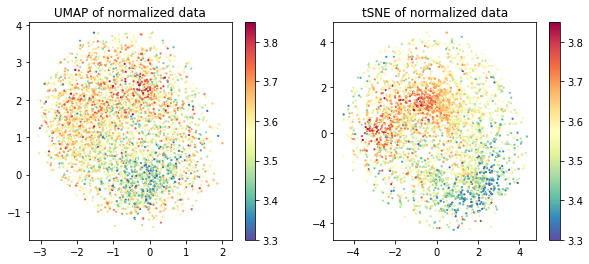

In [25]:
side_by_side(tsne_output,umap_output,reduced_df, norm_df, 'normalized data')

In [35]:
umap_output = perform_umap(pca_results,neighbors=50)
perform_tsne = (25,pca_results,30,log_df)

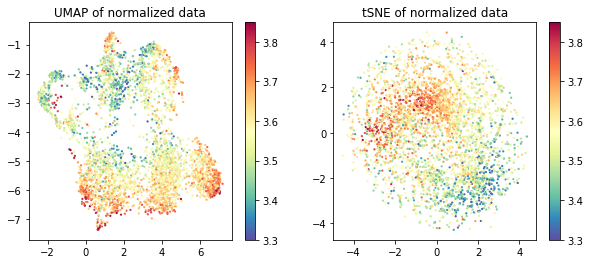

In [36]:
side_by_side(tsne_output,umap_output,reduced_df, norm_df, 'normalized data')

# Q1B

the embedding suggests continuous trajectories charicterizing the heterogenaity in the T cells, rather than distinct groups. 

# Q1c 
the robustness of clusters given from Louvain do/do not change when k in knn graph changes

# Q2A
Compute a Diffusion map representation of the log normalized data using scanpy.tl.diffmap or any other implementation of your choice. What is the size of each diffusion component (eigenvector)? [15pt]

each diffusion component is of length 4076, which is the number of cells.

In [51]:
import anndata
ad = anndata.AnnData(X=log_df, obs = barcode_df.loc[log_df.index], var = gene_df.loc[log_df.columns])

Transforming to str index.
Transforming to str index.


In [52]:
ad

AnnData object with n_obs × n_vars = 4076 × 14552 
    obs: 'barcode'
    var: 'geneid', 'gene_name'

In [54]:
scanpy.pp.neighbors(ad,n_pcs=25,method='umap')

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [55]:
scanpy.tl.diffmap(ad)

In [64]:
diffusion_components = ad.obsm['X_diffmap']

In [65]:
print("diffusion component shape: ",diffusion_components.shape)
print("size of single diffustion component (eigenvector): ",diffusion_components.T[0].shape)

diffusion component shape:  (4076, 15)
size of single diffustion component (eigenvector):  (4076,)


# Q2b.
Color the embedding in Q1a with the first 3 diffusion components found in Q2a[15 pts].

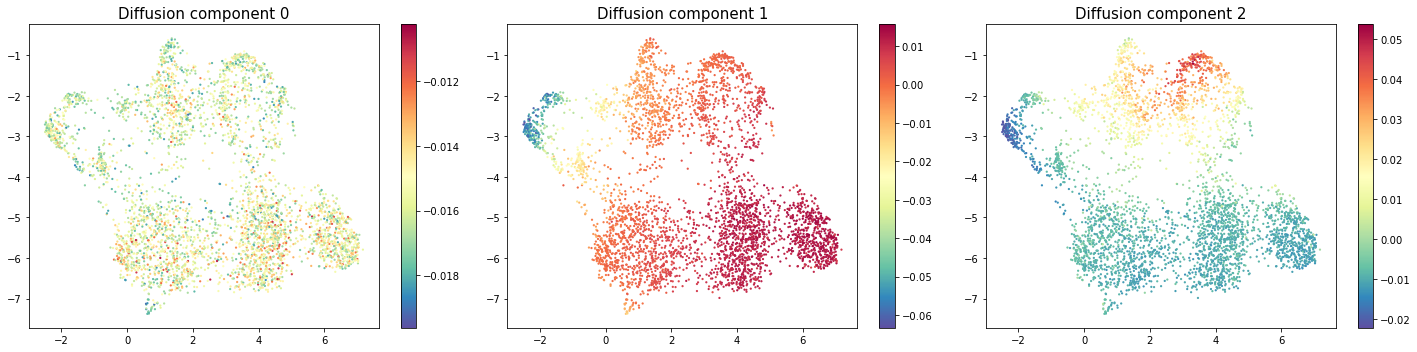

In [79]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
#Diff component 1
plot1=ax[0].scatter(umap_output[:, 0],umap_output[:, 1],s=5, edgecolors='none',
        cmap=matplotlib.cm.Spectral_r, c=diffusion_components.T[0])
ax[0].set_title("Diffusion component 0",fontsize=15)
fig.colorbar(plot1,ax=ax[0])
#diff component 2
plot2=ax[1].scatter(umap_output[:, 0],umap_output[:, 1],s=5, edgecolors='none',
        cmap=matplotlib.cm.Spectral_r, c=diffusion_components.T[1])
ax[1].set_title("Diffusion component 1",fontsize=15)
fig.colorbar(plot2,ax=ax[1])
#diff component 3
plot2=ax[2].scatter(umap_output[:, 0],umap_output[:, 1],s=5, edgecolors='none',
        cmap=matplotlib.cm.Spectral_r, c=diffusion_components.T[2])
ax[2].set_title("Diffusion component 2",fontsize=15)
fig.colorbar(plot2,ax=ax[2])
fig.tight_layout()

# Q2c. 

Project the T cells in the space of the first two diffusion components. How does the structure compare to the visualization of the same cells with tSNE or Umap? [10 pt]
